In [2]:
import sys
import os
import scipy.ndimage as nd
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as sk
from utils import utils
plt.style.use('ggplot')

In [3]:
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data

import torch
import PIL.ImageOps

In [4]:
available_device = "cuda" if torch.cuda.is_available() else "cpu"

#### Load dataset

In [5]:
transformations = [tfs.RandomAffine(0., scale=(0.5, 1.), fillcolor=0),
                   tfs.Resize((64, 64)),
                   tfs.Grayscale(1),
                   tfs.Lambda(lambda x: PIL.ImageOps.invert(x))]

imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',
                                     transform=tfs.Compose(transformations))

data_loader = data.DataLoader(imagenet_data, batch_size=4, shuffle=True)

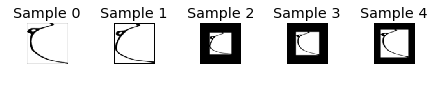

In [6]:
fig = plt.figure()

for i in range(len(imagenet_data)):
    sample = imagenet_data[i + 10]
    #print(sample)
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    plt.imshow(np.asarray(sample[0]), cmap=plt.cm.gray_r)
    ax.set_title('Sample {}'.format(i))
    ax.axis('off')

    if i == 4:
        plt.show()
        break

#### Process type of vessels for classification

In [7]:
df = utils.create_df_from_files(path='data/perfiles_CATA/clases/')

#### Build and train classifier

In [8]:
imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',
                                     transform=tfs.Compose([tfs.RandomHorizontalFlip(p=0.7),
                                                           tfs.RandomAffine(0, scale=(0.7, 1.), fillcolor=0),
                                                           tfs.Resize((64, 64)),
                                                           tfs.Grayscale(1),
                                                           tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
                                                           tfs.ToTensor(),
                                                           tfs.Normalize((0.5,), (0.5,))]))


In [9]:
splits_len = round(len(imagenet_data.samples)*0.2), round(len(imagenet_data.samples)*0.1), round(len(imagenet_data.samples)*0.7)

In [10]:
splits_len = splits_len if np.sum(splits_len) == len(imagenet_data.samples) else splits_len[0], splits_len[1], splits_len[2]+1

#### Random split

In [11]:
splits = utils.random_split(imagenet_data, splits_len)

train_loader = data.DataLoader(splits[2], batch_size=32, shuffle=True)
val_loader = data.DataLoader(splits[1], batch_size=32, shuffle=True)
test_loader = data.DataLoader(splits[0], batch_size=32, shuffle=True)


In [12]:
import torch.optim as optim
from torch import nn
from models.classifier import _C
import visdom
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import TopKCategoricalAccuracy, Loss
from ignite.handlers import ModelCheckpoint
import torch.nn.functional as F

In [14]:
C =_C(input_h_w=64)
C = C.to(available_device)
criterion = nn.CrossEntropyLoss().to(available_device)
C_optimizer = optim.Adam(C.parameters(), lr=0.0002, betas=(0.5, 0.999))

vis = visdom.Visdom()
log_interval = 10
trainer = create_supervised_trainer(C, C_optimizer, F.cross_entropy, device=available_device)

handler_checkpoint = ModelCheckpoint('models/checkpoint_data', 'cnn_vessels', save_interval=2, n_saved=2, create_dir=True, require_empty=False, save_as_state_dict=True)
trainer.add_event_handler(Events.EPOCH_COMPLETED, handler_checkpoint, {'model': C, 'optimizer': C_optimizer})


evaluator = create_supervised_evaluator(C, metrics={'accuracy': TopKCategoricalAccuracy(),
                                                     'ce_ll': Loss(F.cross_entropy)},
                                           device=available_device)


train_avg_loss_window = utils.create_plot_window(vis, '#Iterations', 'Loss', 
                                                 'Training Average Loss')
train_avg_accuracy_window = utils.create_plot_window(vis, '#Iterations', 'Accuracy',
                                                     'Training Average Accuracy')
val_avg_loss_window = utils.create_plot_window(vis, '#Epochs', 'Loss',
                                               'Validation Average Loss')
val_avg_accuracy_window = utils.create_plot_window(vis, '#Epochs', 'Accuracy',
                                                   'Validation Average Accuracy')


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_nll = metrics['ce_ll']
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_nll))
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_accuracy]),
             win=train_avg_accuracy_window, update='append')
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_nll]),
             win=train_avg_loss_window, update='append')

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_nll = metrics['ce_ll']
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_nll))
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_accuracy]),
             win=val_avg_accuracy_window, update='append')
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_nll]),
             win=val_avg_loss_window, update='append')

trainer.run(train_loader, max_epochs=500)

/home/pablo/miniconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training Results - Epoch: 1  Avg accuracy: 0.82 Avg loss: 2.33
Validation Results - Epoch: 1  Avg accuracy: 0.90 Avg loss: 2.32
Training Results - Epoch: 2  Avg accuracy: 0.88 Avg loss: 2.05
Validation Results - Epoch: 2  Avg accuracy: 0.89 Avg loss: 2.01
Training Results - Epoch: 3  Avg accuracy: 0.90 Avg loss: 1.88
Validation Results - Epoch: 3  Avg accuracy: 0.91 Avg loss: 1.87
Training Results - Epoch: 4  Avg accuracy: 0.90 Avg loss: 1.85
Validation Results - Epoch: 4  Avg accuracy: 0.91 Avg loss: 1.83
Training Results - Epoch: 5  Avg accuracy: 0.92 Avg loss: 1.82
Validation Results - Epoch: 5  Avg accuracy: 0.92 Avg loss: 1.78
Training Results - Epoch: 6  Avg accuracy: 0.91 Avg loss: 1.80
Validation Results - Epoch: 6  Avg accuracy: 0.91 Avg loss: 1.79
Training Results - Epoch: 7  Avg accuracy: 0.89 Avg loss: 1.79
Validation Results - Epoch: 7  Avg accuracy: 0.90 Avg loss: 1.78
Training Results - Epoch: 8  Avg accuracy: 0.89 Avg loss: 1.87
Validation Results - Epoch: 8  Avg accura

In [16]:
from torchsummary import summary
if available_device == "cuda":
    summary(C, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,088
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,200
       BatchNorm2d-4          [-1, 128, 16, 16]             256
              ReLU-5          [-1, 128, 16, 16]               0
            Linear-6                 [-1, 1024]      33,555,456
       BatchNorm1d-7                 [-1, 1024]           2,048
              ReLU-8                 [-1, 1024]               0
            Linear-9                   [-1, 11]          11,275
          Softmax-10                   [-1, 11]               0
Total params: 33,701,323
Trainable params: 33,701,323
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.77
Params size (MB): 128.56
Est

### Confusion matrix and classification report

In [17]:
import torchnet

confusion_window = utils.create_plot_window(vis, 'True Labels', 'Predicted', 'Confusion Matrix')

confusion_matrix = torchnet.meter.ConfusionMeter(11, normalized=True)
for ii, data_ in enumerate(test_loader):
    input_, label = data_
    val_input = Variable(input_).to(available_device)
    val_label = Variable(label.type(torch.LongTensor)).to(available_device)
    score = C(val_input)
    confusion_matrix.add(score.data.squeeze(), label.type(torch.LongTensor))
    
np.set_printoptions(precision=3)
print(confusion_matrix.value())
print(confusion_matrix.conf)
vis.heatmap(confusion_matrix.value(), win=confusion_window)

[[1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.973 0.027 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.955 0.    0.    0.    0.    0.    0.    0.045 0.   ]
 [0.    0.067 0.    0.6   0.067 0.    0.    0.    0.    0.267 0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.9   0.    0.    0.    0.1  ]
 [0.    0.    0.    0.    0.1   0.    0.1   0.5   0.    0.2   0.1  ]
 [0.    0.    0.    0.    0.111 0.    0.    0.    0.833 0.    0.056]
 [0.    0.    0.    0.    0.079 0.    0.    0.    0.    0.908 0.013]
 [0.    0.    0.    0.    0.5   0.    0.    0.    0.    0.    0.5  ]]
[[10  0  0  0  0  0  0  0  0  0  0]
 [ 0 72  2  0  0  0  0  0  0  0  0]
 [ 0  0 21  0  0  0  0  0  0  1  0]
 [ 0  1  0  9  1  0  0  0  0  4  0]
 [ 0  0  0  0 17  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  9  

In [18]:
from sklearn import metrics

def iterations_test(C, test_loader):
    y_real = list()
    y_pred = list()

    for ii, data_ in enumerate(test_loader):
        input_, label = data_
        val_input = Variable(input_).to(available_device)
        val_label = Variable(label.type(torch.LongTensor)).to(available_device)
        score = C(val_input)
        _, y_pred_batch = torch.max(score, 1)
        y_pred_batch = y_pred_batch.cpu().squeeze().numpy()
        y_real_batch = val_label.cpu().data.squeeze().numpy()
        y_real.append(y_real_batch.tolist())
        y_pred.append(y_pred_batch.tolist())

    y_real = [item for batch in y_real for item in batch]
    y_pred = [item for batch in y_pred for item in batch]
    
    return y_real, y_pred

In [19]:
y_real, y_pred = iterations_test(C, test_loader)
print(metrics.classification_report(np.array(y_pred), np.array(y_real)))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.95      0.99      0.97        71
           2       1.00      0.85      0.92        26
           3       0.53      0.80      0.64        10
           4       0.88      0.62      0.73        24
           5       1.00      1.00      1.00         2
           6       1.00      0.91      0.95        11
           7       0.50      1.00      0.67         5
           8       0.83      1.00      0.91        15
           9       0.93      0.90      0.92        79
          10       0.50      0.50      0.50         2

   micro avg       0.89      0.89      0.89       256
   macro avg       0.83      0.86      0.83       256
weighted avg       0.91      0.89      0.90       256



In [20]:
avg_acc = list()
for i in range(5):
    y_real, y_pred = iterations_test(C, test_loader)
    avg_acc.append(metrics.accuracy_score(np.array(y_pred), np.array(y_real)))
print(np.mean(avg_acc), avg_acc)

0.88671875 [0.89453125, 0.88671875, 0.8828125, 0.8828125, 0.88671875]
